# Environment setup

In [ ]:
!pip install tensorflow
!pip install numpy==1.22.0
!pip install h5py --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.8 MB 10.1 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 12.8 MB/s 
     |████████████████████████████████| 17.1 MB 59.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.0
    Uninstalling numpy-1.22.0:
      Successfully uninstalled numpy-1.22.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.


In [ ]:
# Connect to Google Drive

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Copy the dataset from Google Drive to local
!cp "/content/gdrive/My Drive/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

In [ ]:
# Import libraries
%tensorflow_version 2.x
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from keras.regularizers import l2
from keras.utils import plot_model

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Data pre-processing

In [ ]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to 0->mass 1->calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

The data is prepared following these steps:


1.   Import the training and testing data from numpy arrays
2.   Remove the images and labels related to baseline patches (even indices in the arrays)
3.   Adjust the labels for the binary classification problem, so that 0 corresponds to 'mass' and 1 maps to 'calcification'
4.   Normalize the pixels to be in the range (0-1) floating point
5.   Shuffle the training set (and labels accordingly, of course)
6.   Split the training data into 'training' and 'validation' subsets
7.   Build Keras generators for training and validation data



In [ ]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
test_images = test_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='validation')

Train size: 2676 	 Test size: 336
Image size: 150x150


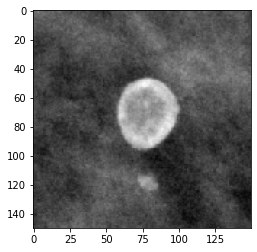

Label: 1


In [ ]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

# Classification

The first step is to discover how large the model should be approximately. A network that is too small won't be able to generalize well; on the other side, a model with too many parameters may learn slowly and overfit.

A good way to find the appropriate size is to start from a small naive model, then gradually increase its size until it starts overfitting while learning; at that point it is flexible enough to fit the training data, and potentially generalizable to other data with a proper training.

Of course, the model can be refined later, by adding new layers, modifying existing ones, including regularization techniques or tuning the hyperparameters, in order to achieve (hopefully) better performances.

Let's start with a very small CNN, made of 2 convolutional layers interleaved with max-pooling. At the end, after a fully-connect layer, a single neuron with sigmoid activation generates the output (binary classification).

As already mentioned, the aim is to get a rough idea of the required model complexity.

The loss function is the binary cross-entropy, which is particularly suitable for this kind of problem (binary classification). The optimizer is RMSprop, an adaptive optimization algorithm which is considered quite efficient.
During the training, we monitor how the loss evolves on the validation set too and save the corresponding model weights when that loss is minimum, since it is where the model usually performs best.

## Experiment 2

Before changing the architectural layout, another regularization method is applied to the previous model to further mitigate overfitting: ***data augmentation***. With data augmentation, the network is trained with a higher number of different samples, generated by applying predefined transformations to the original data. Common techniques are image flipping, shifting, rotation, scaling, distortion, noise injection.

In order to exploit data augmentation, the Keras image generator must be reinitialized with proper arguments. 
As proposed in other studies, we use these augmentation methods:

*   Flipping (horizontal and vertical)
*   Rotation (angle between 0 and 180 degrees)
*   Shear (10 deg)
*   Scale (0.2)



In [ ]:
# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='validation')

In [ ]:
# Model 2

model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
# Callback for checkpointing
checkpoint = ModelCheckpoint('model_2_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_2 = model_2.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 32,
        epochs=3,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_2, 'model_2_2cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

<ipython-input-10-e13e477bd42e>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_2 = model_2.fit_generator(


Epoch 1/3
66/66 [==============================] - ETA: 0s - loss: 0.6965 - accuracy: 0.5334
Epoch 1: val_loss improved from inf to 0.69233, saving model to model_2_2cl_best.h5
66/66 [==============================] - 16s 100ms/step - loss: 0.6965 - accuracy: 0.5334 - val_loss: 0.6923 - val_accuracy: 0.5252
Epoch 2/3
66/66 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5472
Epoch 2: val_loss improved from 0.69233 to 0.68971, saving model to model_2_2cl_best.h5
66/66 [==============================] - 6s 90ms/step - loss: 0.6913 - accuracy: 0.5472 - val_loss: 0.6897 - val_accuracy: 0.5252
Epoch 3/3
66/66 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5500
Epoch 3: val_loss improved from 0.68971 to 0.68933, saving model to model_2_2cl_best.h5
66/66 [==============================] - 6s 92ms/step - loss: 0.6923 - accuracy: 0.5500 - val_loss: 0.6893 - val_accuracy: 0.5252
cp: target '/content/gdrive/My Drive/models/' is not a directory


In [ ]:
# History of accuracy and loss
tra_loss_2 = history_2.history['loss']
tra_acc_2 = history_2.history['accuracy']
val_loss_2 = history_2.history['val_loss']
val_acc_2 = history_2.history['val_accuracy']

# Total number of epochs training
epochs_2 = range(1, len(tra_acc_2)+1)
end_epoch_2 = len(tra_acc_2)

# Epoch when reached the validation loss minimum
opt_epoch_2 = val_loss_2.index(min(val_loss_2)) + 1

# Loss and accuracy on the validation set
end_val_loss_2 = val_loss_2[-1]
end_val_acc_2 = val_acc_2[-1]
opt_val_loss_2 = val_loss_2[opt_epoch_2-1]
opt_val_acc_2 = val_acc_2[opt_epoch_2-1]

# Loss and accuracy on the test set
opt_model_2 = models.load_model('model_2_2cl_best.h5')
test_loss_2, test_acc_2 = model_2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_2, opt_test_acc_2 = opt_model_2.evaluate(test_images, test_labels, verbose=False)
opt_pred_2 = opt_model_2.predict(test_images)
pred_classes_2 = np.rint(opt_pred_2)

print("Model 2\n")

print("Epoch [end]: %d" % end_epoch_2)
print("Epoch [opt]: %d" % opt_epoch_2)
print("Valid accuracy [end]: %.4f" % end_val_acc_2)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_2)
print("Test accuracy [end]:  %.4f" % test_acc_2)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_2)
print("Valid loss [end]: %.4f" % end_val_loss_2)
print("Valid loss [opt]: %.4f" % opt_val_loss_2)
print("Test loss [end]:  %.4f" % test_loss_2)
print("Test loss [opt]:  %.4f" % opt_test_loss_2)

print(classification_report(test_labels, pred_classes_2, digits=4))

11/11 [==============================] - 0s 10ms/step
Model 2

Epoch [end]: 3
Epoch [opt]: 3
Valid accuracy [end]: 0.5252
Valid accuracy [opt]: 0.5252
Test accuracy [end]:  0.4673
Test accuracy [opt]:  0.4673
Valid loss [end]: 0.6893
Valid loss [opt]: 0.6893
Test loss [end]:  0.6959
Test loss [opt]:  0.6959
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       179
           1     0.4673    1.0000    0.6369       157

    accuracy                         0.4673       336
   macro avg     0.2336    0.5000    0.3185       336
weighted avg     0.2183    0.4673    0.2976       336



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


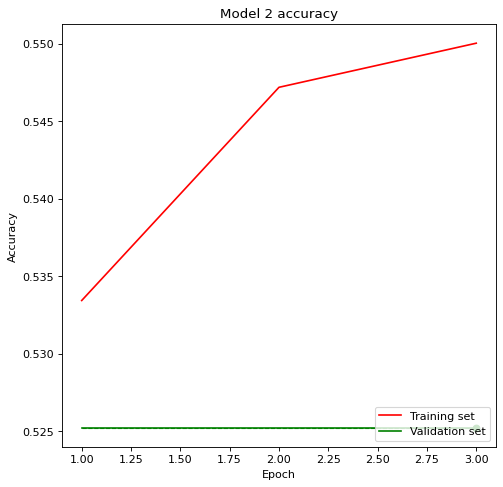

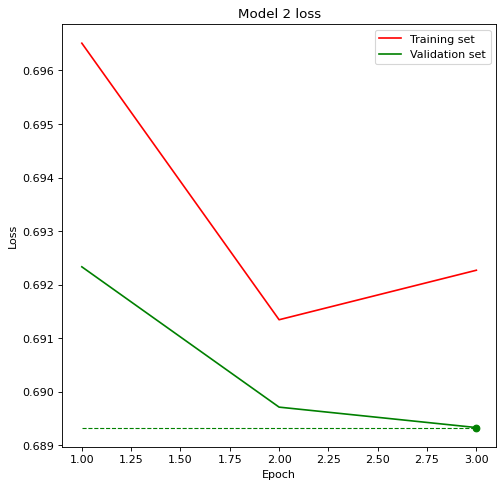

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_acc_2, 'r', label='Training set')
plt.plot(epochs_2, val_acc_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_acc_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_acc_2), opt_val_acc_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_loss_2, 'r', label='Training set')
plt.plot(epochs_2, val_loss_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_loss_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_loss_2), opt_val_loss_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend();

**Result**: thanks to data augmentation, overfitting is no longer present, as both training and validation loss decreased over time (with some noise). 
The accuracy slightly dropped because augmentation makes the learning task harder by design, however the network kept learning during the whole run, as the training accuracy suggests; actually, after 100 epochs, there was still room for improvement. In the future experiments, a smarter strategy will be adopted to choose the number of epochs, to avoid halting the training too early.
Two more considerations can be made. First, the optimization process was quite noisy, which could be a symptom of a too small batch size.
Second, the validation accuracy was consistently greater than the training one, although the network did not learn from the validation images. This benign effect is often caused by dropout: that layer is indeed disabled when evaluating the accuracy on the validation set, so the output neuron can exploit more information thus producing a more reliable result.